In [1]:
# Missile Command  낙하하는 미사일을 요격하는 게임입니다. 마우스 커서로 조준해서 클릭으로 요격 미사일을 발사하세요 폭풍의 소용돌이에 휘말리면 적 미사일도 폭발 합니다. 화면 아랫 부분에 있는 집이 전멸하면 게임오버입니다.

import sys
from math import hypot
    #이건 **두 점 사이의 거리(피타고라스 거리)**를 계산하려고 임포트 .hypot(x, y)는 사실상 √(x² + y²) 계산을 대신해 주는 함수지.   그래서 보통 물체 간 거리 비교, 충돌 감지, 좌표 이동 계산 같은 그래픽·게임 코드에서 자주 등장해.   hypot(3,4) 는 거리가 5가된다.
import pygame
import time
from random import randint
from pygame.locals import QUIT,Rect,MOUSEMOTION,MOUSEBUTTONDOWN

class House:
    ###집객체
    def __init__(self,xpos):
        self.rect= Rect(xpos,550,40,40)
        self.exploded= False
        strip = pygame.image.load("strip.png")
        self.images = (pygame.Surface((20,20),pygame.SRCALPHA),pygame.Surface((20,20),pygame.SRCALPHA))
            #이 줄은 pygame에서 투명한 두 개의 이미지를 미리 만들어 self.images에 튜플로 저장하는 코드예요
            #Surface는 class로 ()안의 크기로 인스턴스를 하나 만들어라라는 의미이고 ,SRCALPHA는 투명하게
        self.images[0].blit(strip,(0,0),Rect(0,0,20,20))
        self.images[1].blit(strip,(0,0),Rect(20,0,20,20))
    def draw(self):
        ## 집그리기
        if self.exploded:
            SURFACE.blit(self.images[1],self.rect.topleft)
        else:
            SURFACE.blit(self.images[0],self.rect.topleft)

class Missile:
    # 낙하하는 미사일 객체
    def __init__(self):
        self.max_count = 500  #발사부터 지면에 도착하기가지 필요한 시간(카운트)
        self.interval = 1000  #낙하와 낙하의 간격
        self.pos = [0,0]      # 낙하시작점, 도착점
        self.cpos = [0,0]   #현재 낙하 중인 좌표의 x좌표,y 좌표
        self.firetime = 0   # 낙하시작시각
        self.radius =0      #폭풍반경
        self.reload(0)     # 메서드로 미사일을 초기화한다(좌표나 시각등)

    def reload(self,time_count):
        # 미사일 재초기화(낙하 후, 폭발 후)
        house_x = randint(0,12) *60 + 20
        self.pos = (randint(0,800),house_x)
        self.interval = int(self.interval *0.9)
        self.firetime = randint(0,self.interval) + time_count
        self.cpos= [0,0]
        self.radius = 0
    
    def tick(self, time_count,shoot,houses):
        # 미사일 상태 갱신
        is_hit = False
        elapsed = time_count - self.firetime  
        if elapsed < 0: # 미사일 발사시각이 지났는지 여부를 판단한다.
            return
        
        # 폭발중
        if self.radius > 0:  #폭풍반경이 0보다 크면 폭발중임 100보다 크면 재장전
            self.radius += 1
            if self.radius >100:
                self.reload(time_count)
        else:  #그렇지 않을때는 미사일이 이동중임을 나타낸다.
            self.cpos[0] = (self.pos[1]-self.pos[0]) *elapsed / self.max_count  + self.pos[0]
            self.cpos[1] = 575*elapsed / self.max_count
        # 미사일이 이동중이면 요격빔에 맞아 떨어졌나를 판정해야한다.?
        diff = hypot(shoot.shot_pos[0] - self.cpos[0],shoot.shot_pos[1] - self.cpos[1])
            #hypot은 두점간의 거리를 반환하는 함수입니다. 이함수를 이용하여 미사일의 탄두와 요격빔의 탄두거리를 구한다.
        if diff < shoot.radius:
            is_hit= True
            self.radius = 1   #폭발시작
            bomb_sound.play()  #폭풍에 들어 있으면 폭발음 방사
            # 지면에 충돌했다?
        if elapsed > self.max_count:
            self.radius  = 1  #폭발시작
            for house in houses:
                if hypot(self.cpos[0] - house.rect.center[0],self.cpos[1] - house.rect.center[1] )<30:
                    house.exploded = True
        return is_hit

    def draw(self):
        # 미사일 그리기

        pygame.draw.line(SURFACE,(0,255,255),(self.pos[0],0),self.cpos)

        if self.radius > 0:  #폭발중
            rad = self.radius if self.radius < 50 else 100-self.radius
            pos = (int(self.cpos[0]),int(self.cpos[1]))
            pygame.draw.circle(SURFACE,(0,255,255),pos,rad)


    


class Shoot:
    # 스스로 폭발하는 빔 객체
    def __init__(self):
        self.scope= (400,300)       #조준기 의 중심좌표
        self.image = pygame.image.load("scope.png")  #조준기 이미지
        self.count = 0          # 발사하고 나서의 카운크
        self.fire =False        #발사 중인지 아닌지 여부의 플래그
        self.radius = 0         #폭풍반경
        self.shot_pos =(0,0)    # 현재탄투의 위치

    def tick(self):
        # 폭발 중 빔의 위치, 상태를 갱신
        if self.fire:
            self.count += 1

            if 100 <= self.count <200:
                self.radius +=1
                self.count += 1

            elif 200 <= self.count < 300:
                self.radius -= 1
                self.count += 1

            elif self.count >= 300:
                self.fire = False
                self.count =0

    def draw(self):
        ## 빔그리기

        rect = self.image.get_rect()
        rect.center = self.scope
        SURFACE.blit(self.image,rect)

        if not self.fire:
            return
        
        if self.radius ==0 and self.count < 100:
            eat_sound.set_volume(0.2)
            eat_sound.play()
            ratio = self.count / 100
            ypos = 600-(600-self.shot_pos[1])*ratio
            x_left = int((self.shot_pos[0]) * ratio)
            x_right = int((800-(800-self.shot_pos[0])*ratio))

            pygame.draw.line(SURFACE,(250,255,0),(0,600),(x_left,ypos),5)
            pygame.draw.line(SURFACE,(250,255,0),(800,600),(x_right,ypos),5)
        elif self.radius > 0:
            pygame.draw.circle(SURFACE,(255,randint(10,255),10),self.shot_pos,self.radius)
            # if self.radius == 1:
            bang_sound.play()

pygame.init()
SURFACE = pygame.display.set_mode((800,600))
FPSCLOCK = pygame.time.Clock()

bang_sound = pygame.mixer.Sound("bang.wav")   # 짧은 wav/mp3 파일
eat_sound = pygame.mixer.Sound("eat.wav")   # 짧은 wav/mp3 파일
bomb_sound = pygame.mixer.Sound("bomb.mp3")   # 짧은 wav/mp3 파일
# 실행 hit_sound.play()

def main():
    houses = []
    time_count=0    #경과 시간을 관리하는 타이머
    shoot=Shoot()   #스스로 발사한 요격 미사일 객체
    game_over = False
    missiles =[]   #미사일 객체를 저장하는 리스트
    score=0

    scorefont = pygame.font.SysFont(None,36)
    sysfont = pygame.font.SysFont(None,72)
    message_over= sysfont.render("GAME OVER!!",True,(0,255,255))
    message_rect = message_over.get_rect()
    message_rect.center = (400,300)
    for i in range(13):
        houses.append(House(i*60 +20))
    while len(missiles)< 18:
        missiles.append(Missile())

    while True:
        time_count+= 1
        for event in pygame.event.get():
            if event.type == QUIT:
                pygame.quit()
                sys.exit()
            elif event.type == MOUSEMOTION:
                shoot.scope = event.pos
            elif event.type == MOUSEBUTTONDOWN:
                if not shoot.fire:   # shoot.fire 가 False가 아니면  이란 코드임,즉 버튼이 눌리면
                    shoot.shot_pos = shoot.scope
                    shoot.fire = True

        # 1프레임마다 처리
        exploded = len(list(filter(lambda x: x.exploded,houses))) 
            #houses 리스트 안에서, x.exploded가 True인 객체만 걸러냄
        game_over = exploded == 13
        if not game_over:
            for missile in missiles:
                is_hit = missile.tick(time_count,shoot,houses)
                if is_hit:
                    score +=100

            shoot.tick()
        # 그리기
        SURFACE.fill((0,0,0)) 
        shoot.draw()

        for house in houses:
            house.draw()
        for missile in missiles:
            missile.draw()

        score_str = str(score).zfill(6)
        score_image = scorefont.render(score_str,True,(0,255,0))
        SURFACE.blit(score_image,(700,10))

        if game_over:
            SURFACE.blit(message_over,message_rect)

        pygame.display.update()
        FPSCLOCK.tick(20)
        

if __name__ =='__main__':
    main()



c:\Users\고창섭\AppData\Local\Programs\Python\Python313\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


pygame 2.6.1 (SDL 2.28.4, Python 3.13.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


SystemExit: 

C:\Users\고창섭\AppData\Roaming\Python\Python313\site-packages\IPython\core\interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


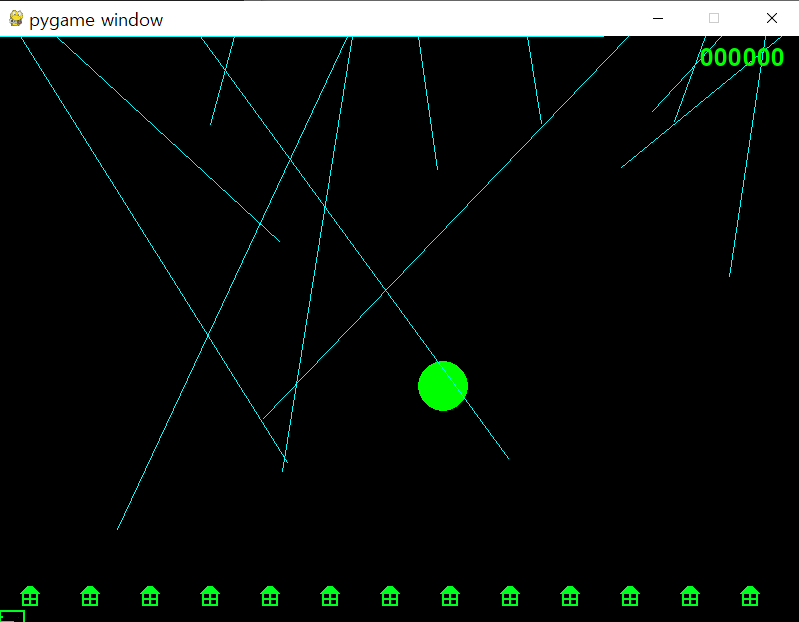